In [1]:
## standart libraries

import os,sys
import numpy as np

import timeit

# xarray
import xarray as xr
import pandas as pd
import datetime
# plot
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.feature as cfeature

# custom tools for plotting
import lib_SLXtools_IMHOTEP_2021 as slx

# for jupyter notebook display
%matplotlib inline

import pkg_resources


In [2]:
# read grid files
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
tmask = xr.open_dataset(diri+'mesh_hgr.nc')['tmask'][0,0,:,:] # grille lat/lon
nav_lon = xr.open_dataset(diri+'mesh_hgr.nc')['nav_lon']
nav_lat = xr.open_dataset(diri+'mesh_hgr.nc')['nav_lat']
mbathy = xr.open_dataset(diri+'eORCA025.L75_domain_cfg_closed_seas_greenland.nc')['bathy_meter'].isel(t=0) # grille lat/lon

In [3]:
prefix = "eORCA025.L75-IMHOTEP"
nexpREF = "GAI"
diridatref="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpREF+"-S/"
fo='1m'

yr=1980
month='09'

filepathREF = diridatref+fo+"/"+str(yr)+"/"+prefix+"."+nexpREF+"_y"+str(yr)+"m"+month+".1m_icemod.nc"
dsmonth = xr.open_dataset(filepathREF,decode_times=False)
dsmonth.sfxice

<xarray.DataArray 'sfxice' (time_counter: 1, y: 1207, x: 1442)>
[1740494 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) float64 ...
  * time_counter   (time_counter) float64 2.547e+09
Dimensions without coordinates: y, x
Attributes:
    long_name:           ice-ocean salt flux from ice growth/melt (neg = growth)
    units:               kg/m2/s
    online_operation:    average
    interval_operation:  1200 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 1200 s)

# loading data

In [4]:
prefix = "eORCA025.L75-IMHOTEP"
nexp = "S"
nexpAI = "AI"
nexpREF = "GAI"

varna = 'sfxice' 

# years to read data from:
y1=1998
y2=2011


fo="1m" # output frequency, could be "1y" or "1m"

#  input directory on store
diridatref="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpREF+"-S/"
diridatAI="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpAI+"-S/"
diridat="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexp+"-S/"

# input directory on work

#  input directory on MY work
dirww ="/gpfswork/rech/cli/uor98hu/myncfiles/"


In [5]:
%%time
# creating a dataset with the variable sivolu for the years over period y1-y2

# for a given simu (here S)

# new numpy matrix
# setting the dimensions: x, y t
t_dim = (y2-y1+1)*12
x_dim = 1442
y_dim = 1207
#creating the 3 matrix to obtain
sivolu_matrix = np.ones((t_dim, y_dim, x_dim))
sivolu_matrixREF = np.ones((t_dim, y_dim, x_dim))
sivolu_matrixAI = np.ones((t_dim, y_dim, x_dim))

yr_counter =0
for yr in np.arange(y1,y2+1):
    for month in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
        filepath = diridat+fo+"/"+str(yr)+"/"+prefix+"."+nexp+"_y"+str(yr)+"m"+month+".1m_icemod.nc"
        filepathREF = diridatref+fo+"/"+str(yr)+"/"+prefix+"."+nexpREF+"_y"+str(yr)+"m"+month+".1m_icemod.nc"
        filepathAI = diridatAI+fo+"/"+str(yr)+"/"+prefix+"."+nexpAI+"_y"+str(yr)+"m"+month+".1m_icemod.nc"

        #opening the file
        S1y = xr.open_dataset(filepath,decode_times=False)[varna]
        REF1y = xr.open_dataset(filepathREF,decode_times=False)[varna]
        AI1y = xr.open_dataset(filepathAI,decode_times=False)[varna]

        # Saving the yearly data in the new matrix
        sivolu_matrix[yr_counter,:,:]   = S1y.isel(time_counter=0).values
        sivolu_matrixREF[yr_counter,:,:]= REF1y.isel(time_counter=0).values
        sivolu_matrixAI[yr_counter,:,:] = AI1y.isel(time_counter=0).values
        #print(yr)
        yr_counter+=1


CPU times: user 35.2 s, sys: 4.29 s, total: 39.5 s
Wall time: 1min 50s


In [6]:
#S1y

# converting the matrixes into datarray easy to use

In [7]:
%%time
#creating the coordinates for the datarray
time = pd.date_range(start=str(y1), end=str(y2+1), freq='M')
lats = nav_lat.values
longs = nav_lon.values

dasfxice = xr.DataArray(data=sivolu_matrix, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="ice-ocean salt flux from ice growth/melt (neg = growth)",units="kg/m2/s"))

dasfxiceREF = xr.DataArray(data=sivolu_matrixREF, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="ice-ocean salt flux from ice growth/melt (neg = growth)",units="kg/m2/s"))

dasfxiceAI = xr.DataArray(data=sivolu_matrixAI, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="ice-ocean salt flux from ice growth/melt (neg = growth)",units="kg/m2/s"))

CPU times: user 80.1 ms, sys: 11.9 ms, total: 92.1 ms
Wall time: 101 ms


In [8]:
dasfxice

<xarray.DataArray (time_counter: 168, y: 1207, x: 1442)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lon           (y, x) float32 72.75 73.0 73.25 73.5 ... 73.01 73.01 73.0 73.0
    lat           (y, x) float32 -84.2 -84.2 -84.2 -84.2 ... 50.02 50.0 50.0
  * time_counter  (time_counter) datetime64[ns] 1998-01-31 ... 2011-12-31
Dimensions without coordinates: y, x
Attributes:
    description:  ice-ocean salt flux from ice growth/melt (neg = growth)
    units:        kg/m2/s

In [9]:
# plotting 

### converting to salt exchage rate (kg/s)

In [10]:
e1t = xr.open_dataset(diri+'mesh_hgr.nc')['e1t']
e2t = xr.open_dataset(diri+'mesh_hgr.nc')['e2t']
#surface of each cell
cellArea = e1t.isel(time_counter=0)*e2t.isel(time_counter=0) 

# calculating the volume for each pixel
darateice   = dasfxice*cellArea
darateiceREF= dasfxiceREF*cellArea
darateiceAI = dasfxiceAI*cellArea

# selecting the Arctic only
Arctic_darateice = darateice.where(darateice.lat>0, drop=False)
Arctic_darateiceREF = darateiceREF.where(darateiceREF.lat>0, drop=False)
Arctic_darateiceAI = darateiceAI.where(darateiceAI.lat>0, drop=False)

In [11]:
#summing over the whole arctic Ocean : DM total for the Arctic Ocean
dasfxiceDmTotREF= Arctic_darateiceREF.sum(('x','y'))
dasfxiceDmTotAI = Arctic_darateiceAI.sum(('x','y'))
dasfxiceDmTot   = Arctic_darateice.sum(('x','y'))

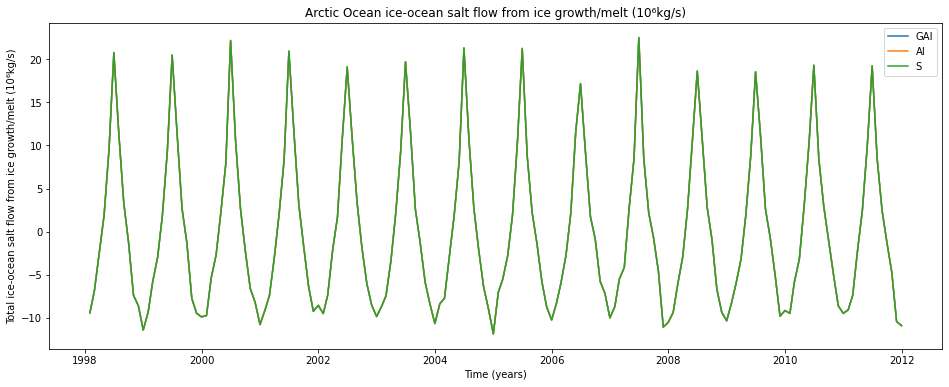

from monthly data


In [13]:
# time series of total Arctic sea ice Dm for the three simulations
plt.figure(figsize=([16,6]),facecolor='white')
plt.plot(time,dasfxiceDmTotREF/1e6)
plt.plot(time,dasfxiceDmTotAI/1e6)
plt.plot(time,dasfxiceDmTot/1e6)
plt.legend(['GAI','AI','S'])

plt.title('Arctic Ocean ice-ocean salt flow from ice growth/melt (10⁶kg/s)')
plt.xlabel('Time (years)')
plt.ylabel('Total ice-ocean salt flow from ice growth/melt (10⁶kg/s)')

plt.show()
print("from monthly data")

#### in the box BG

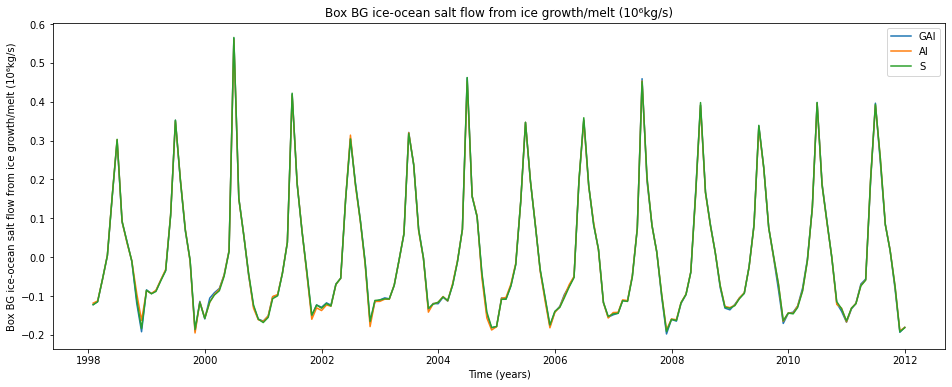

from monthly data


In [14]:
# selecting the BOx BG only
BoxBG_dasfxiceDmREF = darateiceREF.where((darateiceREF.lon>-152.5) & (darateiceREF.lon<-140.5) &
                            (darateiceREF.lat>72.3) & (darateiceREF.lat<77.3),drop=False)

BoxBG_dasfxiceDmAI = darateiceAI.where((darateiceAI.lon>-152.5) & (darateiceAI.lon<-140.5) &
                            (darateiceAI.lat>72.3) & (darateiceAI.lat<77.3),drop=False)

BoxBG_dasfxiceDm = darateice.where((darateice.lon>-152.5) & (darateice.lon<-140.5) &
                            (darateice.lat>72.3) & (darateice.lat<77.3),drop=False)

#summing over the Box BG : DM total for the Box
BoxBG_dasfxiceDmREF= BoxBG_dasfxiceDmREF.sum(('x','y'))
BoxBG_dasfxiceDmAI = BoxBG_dasfxiceDmAI.sum(('x','y'))
BoxBG_dasfxiceDm   = BoxBG_dasfxiceDm.sum(('x','y'))

# time series of total Arctic sea ice Dm for the three simulations
plt.figure(figsize=([16,6]),facecolor='white')
plt.plot(time,BoxBG_dasfxiceDmREF/1e6)
plt.plot(time,BoxBG_dasfxiceDmAI/1e6)
plt.plot(time,BoxBG_dasfxiceDm/1e6)
plt.legend(['GAI','AI','S'])

plt.title('Box BG ice-ocean salt flow from ice growth/melt (10⁶kg/s)')
plt.xlabel('Time (years)')
plt.ylabel('Box BG ice-ocean salt flow from ice growth/melt (10⁶kg/s)')

plt.show()
print("from monthly data")

In [16]:
BoxBG_dasfxiceDmREF_AI = (BoxBG_dasfxiceDmREF - BoxBG_dasfxiceDmAI)/1e6
BoxBG_dasfxiceDmREF_S = (BoxBG_dasfxiceDmREF - BoxBG_dasfxiceDm)/1e6
BoxBG_dasfxiceDmAI_S = (BoxBG_dasfxiceDmAI - BoxBG_dasfxiceDm)/1e6


In [23]:
print('mean diff GAI-AI ',BoxBG_dasfxiceDmREF_AI.mean().values)
print('mean diff GAI-S ',BoxBG_dasfxiceDmREF_S.mean().values)
print('mean diff AI-S ',BoxBG_dasfxiceDmAI_S.mean().values)

mean diff GAI-AI  -3.84653388086119e-05
mean diff GAI-S  -0.00040259426865068984
mean diff AI-S  -0.000364128929842078


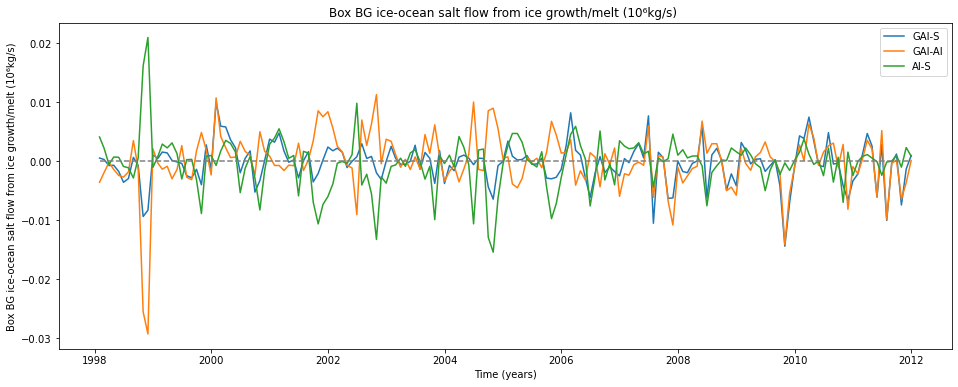

from monthly data


In [19]:
# time series of Box BG Arctic sea ice volume for the three simulations
plt.figure(figsize=([16,6]),facecolor='white')
plt.plot(time,BoxBG_dasfxiceDmREF_S)
plt.plot(time,BoxBG_dasfxiceDmREF_AI)
plt.plot(time,BoxBG_dasfxiceDmAI_S)
plt.plot(time,np.zeros(168),linestyle='--', color='grey')
plt.legend(['GAI-S','GAI-AI','AI-S'])
plt.title('Box BG ice-ocean salt flow from ice growth/melt (10⁶kg/s) ')
plt.xlabel('Time (years)')
plt.ylabel('Box BG ice-ocean salt flow from ice growth/melt (10⁶kg/s)')

plt.show()
print("from monthly data")

# Brouillon calcul du ice halostéric effect

In [ ]:
beta = 8*1e-4
h = 300 #m
halorate = -beta * h * Arctic_darateice
halorateREF = -beta * h * Arctic_darateiceREF
halorateAI = -beta * h * Arctic_darateiceAI

# time series of total Arctic sea ice volume for the three simulations
plt.figure(figsize=([16,6]),facecolor='white')
plt.plot(time,Tot_Arctic_dasiVOlu)
plt.plot(time,Tot_Arctic_dasiVOluREF)
plt.plot(time,Tot_Arctic_dasiVOluAI)
plt.legend(['S','GAI','AI'])
   
plt.show()
print("from annual data")

Seaicevolume_2001_1y_GAI.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


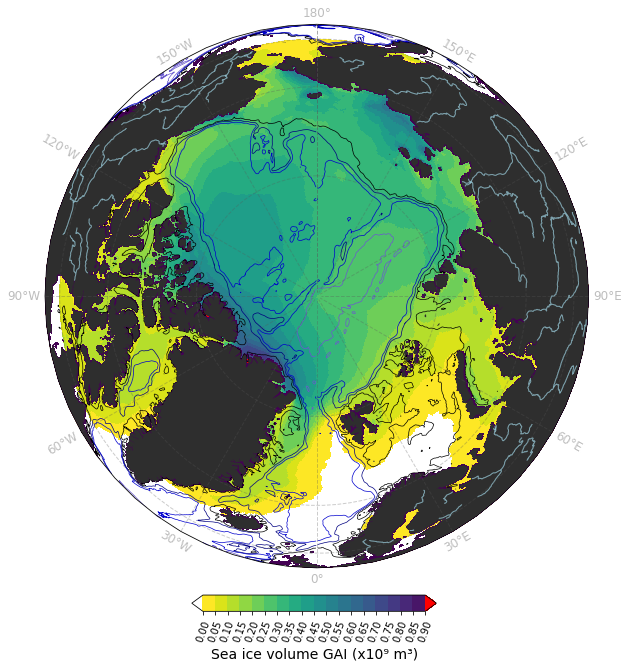

In [12]:
# Map to see sea ice volume in the Arctic
reg = 'gro'

# RUN to PLOT

#========= DATA TO PLOT
for iexp in ['nexpREF']: #'DIFFGAIAI' 'DIFFGAIS','DIFFAIS','DIFFGAIGA','DIFFGAIGI']:

    # main variable
    if iexp=='nexpREF':
        data = Arctic_dasiVOluREF.sel(time_counter='2001')/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume "+nexpREF+" (x10⁹ m³)" #" over "+y1+"-"+y2 # SSH
        namo = "Seaicevolume_2001_"+fo+"_"+nexpREF+".png"
        print(namo)


    # lat lon
    lon2plot   = nav_lon.squeeze()
    lat2plot   = nav_lat.squeeze()
    # land mask from model
    m2plt      = tmask.where(tmask==0)

    #========= Plot settings ===============
    levbounds=[0,0.95,0.05]  # varna sossh eig

    # COLORMAP
    co='vi' # inferno
    #add indication of colormap to the plot name:
    #namo = co+namo

    # color for continents from data based (hi-res)
    onecohrml='#2E2E2E'

    # customed colormapls
    if (co=='in'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

    if (co=='vi'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='viridis_r',cu='w',co='r')

    if (co=='coolwarm'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='seismic',cu='midnightblue',co='darkred')

    if (co=='Spectral'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='Spectral_r',cu='w',co='r')


    # default gridlines parameters
    gridl=False
    incrgridlon=30
    incrgridlat=10


    loncentr=0
    latcentr=90
    sath=2085831


    #================================================================
    #========= CREATE FIGURE
    fig3 = plt.figure(figsize=([18,10]),facecolor='white')

    #========= PLOT DATA
    # Data system proj (if coords are in lat lon, use PlateCarre here)
    trdata  = ccrs.PlateCarree() 

    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,
                                                       satellite_height=sath))

    cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

    # plot grey shading  where ocean mask is 0 (land gridpoints in the model)
    cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',
                          transform=trdata) # cmap=slx.make_SLXcolormap(reverse=False)

    
    ##============= BATHYMETRY
    # Add 1000 and 200 meters bathymetry lines and labels. We will apply a Gaussian filter to smooth the data. 
    bathy_levels = [200,1000,2000,4000]
    color_levels= ['k','navy','mediumblue','slateblue']
    # west
    Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)
    # east
    Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)

    #========= coastlines and gridlines

    # cartopy basic options for coastlines
    #cl = ax.coastlines(color= '#BDBDBD')
    #
    # cartopy FEATURES
    rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', 
                                                 scale='50m',facecolor='none',edgecolor='b')

        #lands = cartopy.feature.NaturalEarthFeature(
        #    category='physical', name='coastline',
        #    scale='50m',facecolor='none',edgecolor='k')

    cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor=onecohrml,edgecolor= 'none',alpha=1,zorder=5)
    clr = ax.add_feature(cartopy.feature.RIVERS,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)
    clr2 = ax.add_feature(rivers,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)  ##CEE3F6

    #========= GRIDLINES
    gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
    label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
    gl.xlabel_style = label_style
    #gl.xlabels_bottom = False
    gl.ylabel_style = label_style
    #gl.ylabels_right = False

    #========= ADD COLORBAR
    cbon=True
    if cbon:
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=1,tformat="%.2f",
                            tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  

    #========= PLT SHOW
    plt.show()    # rgb color for model land grid points
    #slx.saveplt(fig3,diro,namo,dpifig=300)
    plt.close(fig3)